In this notebook, I will create a function that gives a LIME explanation of every time series regression model.
If we don't have LIME install, we should import it:

In [2]:
%pip install lime
%pip install tslearn
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [143]:
from lime.lime_tabular import RecurrentTabularExplainer
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
import re
import heapq

def explain_model(X_train, model, x_test, features_names=None):
    explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=features_names)
    explained = explainer.explain_instance(x_test, classifier_fn=model.predict, num_samples=90000)
    print("Predicted LIME Value: ", explained.local_pred)
    explained.as_pyplot_figure()
    list(map(lambda x: print(x), explained.as_list()))
    explained.show_in_notebook()

    print("Based on the LIME explanation, the following features had the most influence on the model's prediction:")
    features = explained.as_list()
    features_without_time = {}

    for feature in features:
        # Incubi con le regex
        match1 = re.search(r'^(.*?)_t-', feature[0])
        match2 = re.search(r'<\s*(.*?)_t-', feature[0])

        if match1:
            feature_name = match1.group(1)
        if match2:
            feature_name = match2.group(1)

        value = feature[1]

        if feature_name in features_without_time:
            features_without_time[feature_name] += value
        else:
            features_without_time[feature_name] = value

    for idx, (name, value) in enumerate(features_without_time.items()):
        if idx < len(features_without_time) - 1:
            print(f"{name}, with a weight of {round(value, 6)}", end=',\n')
        else:
            print(f"{name}, with a weight of {round(value, 6)}", end='.\n')
            
        

    # "Based on the LIME explanation, the following features had the most influence on the model’s prediction:
    # [list of the features with their corresponding weights].
    # The model gave more importance to [feature_x] at time step [t] with a weight of [weight_x_t].
    # For this specific instance, it looks like the model relies heavily on [important feature names] to make its prediction.”

    top_feature = explained.as_list()[0] 
    name = top_feature[0]
    match1 = re.search(r'^(.*?)_t-', name)
    match2 = re.search(r'<\s*(.*?)_t-', name)

    if match1:
        name = match1.group(1)
    if match2:
        name = match2.group(1)

    # Another regex nightmare to get the t-x part of the string
    time_step = top_feature[0]
    match1 = re.match(r'(.+)_t-(\d+) [\S\s]*', time_step)
    if match1:
        time_step = match1.group(2)
    match2 = re.match(r'[^<]+<\s*(\S+)_t-(\d+) [\S\s]*', time_step)
    if match2:
        time_step = match2.group(2)
    
    value = top_feature[1]
    print(f"The model gave the most importance to the feature {name} at time step t-{time_step}, with a weight of {round(value, 6)}")

    print("For this specific instance, it looks like the model relies heavily on", end=' ')

    n = 4
    sorted_features = sorted(features_without_time.items(), key=lambda x: abs(x[1]), reverse=True)
    
    top_n = sorted_features[:n]
    for i, item in enumerate(top_n):
        if i < len(top_n) - 1:
            print(item[0], end=', ')
        else:
            print(item[0], end='.\n')





        
#[list of the features with their corresponding weights].
#The model gave more importance to [feature_x] at time step [t] with a weight of [weight_x_t]. For this specific instance, it looks like the model relies heavily on [important feature names] to make its prediction.""")

    return explained
    

Let's try to use a few datasets/models to check the result.
First, this Air Quality dataset:

In [4]:
import pandas as pd

df = pd.read_csv("AirQualityUCI.csv", sep=';')


In [5]:
df.tail(6)

Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9465  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9466  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9467  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9468  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9469  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9470  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   

      PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)    T   RH   AH  \
9465           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9466           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9467           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9468           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9469           NaN      NaN           NaN          NaN  NaN  NaN  NaN   
9470           NaN      NaN           NaN          NaN  NaN  NaN  NaN   

      Unnamed: 15  Unnamed: 16  
9465          NaN          NaN  
9466          NaN          NaN  
9467          NaN          NaN  
9468          NaN          NaN  
9469          NaN          NaN  
9470          NaN          NaN

<AxesSubplot: >

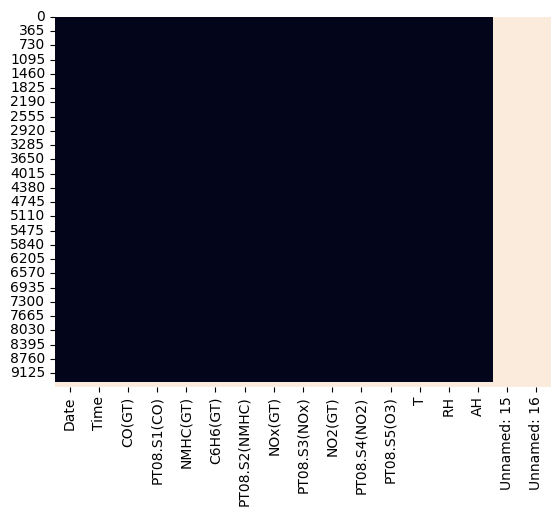

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=False)

Let's drop NaN rows and columns.

In [7]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
df = df.dropna()

In [8]:
df.tail(6)

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
9351  04/04/2005  09.00.00    3,9       1297.0    -200.0     13,6   
9352  04/04/2005  10.00.00    3,1       1314.0    -200.0     13,5   
9353  04/04/2005  11.00.00    2,4       1163.0    -200.0     11,4   
9354  04/04/2005  12.00.00    2,4       1142.0    -200.0     12,4   
9355  04/04/2005  13.00.00    2,1       1003.0    -200.0      9,5   
9356  04/04/2005  14.00.00    2,2       1071.0    -200.0     11,9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
9351         1102.0    523.0         507.0    187.0        1375.0   
9352         1101.0    472.0         539.0    190.0        1374.0   
9353         1027.0    353.0         604.0    179.0        1264.0   
9354         1063.0    293.0         603.0    175.0        1241.0   
9355          961.0    235.0         702.0    156.0        1041.0   
9356         1047.0    265.0         654.0    168.0        1129.0   

      PT08.S5(O3)     T    RH      AH  
9351       1583.0  18,2  36,3  0,7487  
9352       1729.0  21,9  29,3  0,7568  
9353       1269.0  24,3  23,7  0,7119  
9354       1092.0  26,9  18,3  0,6406  
9355        770.0  28,3  13,5  0,5139  
9356        816.0  28,5  13,1  0,5028

There are some columns that represent the decimal with commas, and some that represent it with point. Let's uniform that. 

In [9]:
df['CO(GT)'] = df['CO(GT)'].str.replace(',', '.').astype(float)
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',', '.').astype(float)
df['T'] = df['T'].str.replace(',', '.').astype(float)
df['RH'] = df['RH'].str.replace(',', '.').astype(float)
df['AH'] = df['AH'].str.replace(',', '.').astype(float)


Let's say we want to predict temperature, so we rename that column as Y:

In [10]:
df = df.rename(columns={'T':'Y'})

In [11]:
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      Y    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

I want to use a unique column for DateTime.

In [12]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

df = df.drop(['Date', 'Time'], axis=1)

In [13]:
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     Y    RH      AH  \
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888   

             DateTime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00  
3 2004-03-10 21:00:00  
4 2004-03-10 22:00:00

Our index should be DateTime.

In [14]:
df.set_index('DateTime', inplace=True)

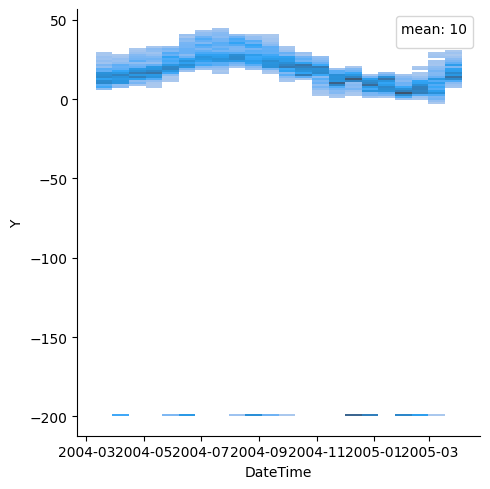

In [15]:
sns.displot(data=df, x='DateTime', y='Y')
plt.legend(title='mean: {:,.0f}'.format(df["Y"].mean()), labels=[])
plt.show()

There are some values that are set to -200 that represent a NaN. I want to substitute them with an interpolation.

In [16]:
import numpy as np
df.replace(-200, np.nan, inplace=True)
df.interpolate(method='linear', axis=0, inplace=True)

Now we generate samples of 7 days.

In [17]:
from sklearn.model_selection import train_test_split

features = df.columns.values
index = np.argwhere(features=='Y')
input_features = np.delete(features, index)
output_feature = np.array(['Y'])
window_size = 7
stride = 1

# create lists to store the samples and labels
samples = []
labels = []

# slide the window over the data and extract samples and labels
for i in range(0, len(df) - window_size+1, stride):
    # extract the input features for this window
    X = df.iloc[i:i+window_size, df.columns != 'Y'].values
    samples.append(X)

    # extract the output feature for this window
    y = df.iloc[i+window_size-1][output_feature]
    labels.append(y)

# convert the lists to numpy arrays
samples = np.array(samples)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, shuffle=False)

Let's create the model now:

In [18]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2,889
Trainable params: 2,889
Non-trainable params: 0
______________________________________________________

And now we fit the model:

In [20]:
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100


2023-04-03 23:30:13.358265: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


59/59 [==============================] - 0s 3ms/step - loss: 3373.2139 - val_loss: 134.9048
Epoch 2/100
59/59 [==============================] - 0s 1ms/step - loss: 477.9706 - val_loss: 134.3966
Epoch 3/100
59/59 [==============================] - 0s 1ms/step - loss: 476.8122 - val_loss: 133.7711
Epoch 4/100
59/59 [==============================] - 0s 1ms/step - loss: 475.4553 - val_loss: 133.0656
Epoch 5/100
59/59 [==============================] - 0s 1ms/step - loss: 473.9555 - val_loss: 132.3020
Epoch 6/100
59/59 [==============================] - 0s 1ms/step - loss: 472.3484 - val_loss: 131.4927
Epoch 7/100
59/59 [==============================] - 0s 1ms/step - loss: 470.6554 - val_loss: 130.6497
Epoch 8/100
59/59 [==============================] - 0s 1ms/step - loss: 468.8953 - val_loss: 129.7782
Epoch 9/100
59/59 [==============================] - 0s 1ms/step - loss: 467.0795 - val_loss: 128.8857
Epoch 10/100
59/59 [==============================] - 0s 1ms/step - loss: 465.2177 -

In [21]:
y_pred = model.predict(X_test)
print(y_pred)

59/59 [==============================] - 0s 417us/step
[[5.2965136]
 [5.2965136]
 [5.2965136]
 ...
 [5.2965136]
 [5.2965136]
 [5.2965136]]


In [22]:
print(y_pred[2])
print(y_test[2])

[5.2965136]
[8.4]


In [23]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_pred, y_test))

5.6483757421716785


Time for explanation! Let's pass to this function a model and see what it can do:

2813/2813 [==============================] - 1s 395us/step
Predicted LIME Value:  [5.29672369]
('NMHC(GT)_t-3 <= 275.00', -0.00014037133963960976)
('PT08.S3(NOx)_t-2 > 979.00', 3.1626684301387404e-05)
('NO2(GT)_t-4 > 126.00', 3.160389883546512e-05)
('816.00 < PT08.S3(NOx)_t-5 <= 979.00', 3.157640992354058e-05)
('49.80 < RH_t-0 <= 62.30', 3.132546805992177e-05)
('PT08.S4(NO2)_t-6 <= 1337.26', 3.121589263173194e-05)
('PT08.S1(CO)_t-2 <= 937.00', 3.114566995053786e-05)
('PT08.S4(NO2)_t-3 <= 1337.00', 3.101502808584093e-05)
('PT08.S4(NO2)_t-2 <= 1337.00', 3.082248246398421e-05)
('PT08.S1(CO)_t-0 <= 936.75', 3.0643805376634616e-05)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
('NMHC(GT)_t-3 <= 275.00', -0.00014037133963960976)  Miao
('PT08.S3(NOx)_t-2 > 979.00', 3.1626684301387404e-05)  Miao
('NO2(GT)_t-4 > 126.00', 3.160389883546512e-05)  Miao
('816.00 < PT08.S3(NOx)_t-5 <= 979.00', 3.157640992354058e-05)  Miao
('49.80 < RH_t-0 <= 62.30', 3.132546805992177e-05)  Miao
('PT08.S4(NO2)_t-6 <= 1337.26', 3.121589263173194e-05)  Miao
('PT08.S1(CO)_t-2 <= 937.00', 3.114566995053786e-05)  Miao
('PT08.S4(NO2)_t-3 <= 1337.00', 3.101502808584093e-05)  Miao
('PT08.S4(NO2)_t-2 <= 1337.00', 3.082248246398421e-05)  Miao
('PT08.S1(CO)_t-0 <= 936.75', 3.0643805376634616e-05)  Miao


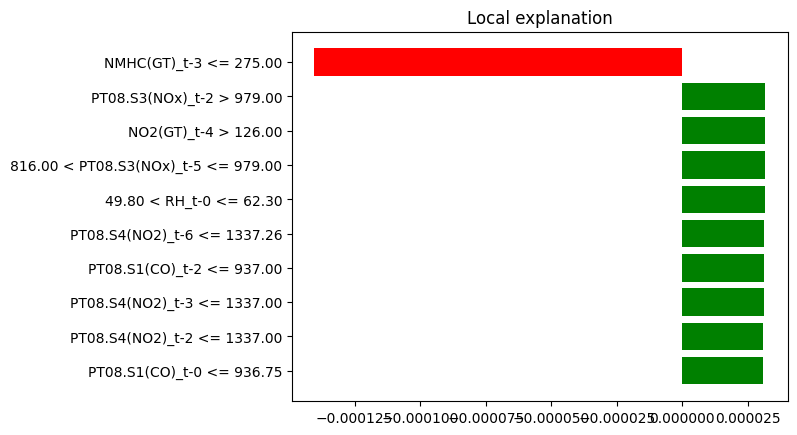

In [24]:
explain_model(X_train, model, X_test[12], features_names=input_features)

Let's try with a different model: LSTM

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
234/234 [==============================] - 2s 3ms/step - loss: 273.7754 - val_loss: 34.3716
Epoch 2/100
234/234 [==============================] - 0s 2ms/step - loss: 138.0276 - val_loss: 44.5553
Epoch 3/100
234/234 [==============================] - 0s 2ms/step - loss: 84.8884 - val_loss: 61.9532
Epoch 4/100
234/234 [==============================] - 0s 2ms/step - loss: 62.6017 - val_loss: 63.3351
Epoch 5/100
234/234 [==============================] - 0s 2ms/step - loss: 50.6212 - val_loss: 55.6397
Epoch 6/100
234/234 [==============================] - 0s 2ms/step - loss: 43.2225 - val_loss: 51.8308
Epoch 7/100
234/234 [==============================] - 0s 2ms/step - loss: 41.7899 - val_loss: 58.3537
Epoch 8/100
234/234 [==============================] - 0s 2ms/step - loss: 37.3674 - val_loss: 53.2772
Epoch 9/100
234/234 [==============================] - 0s 2ms/step - loss: 34.5397 - val_loss: 40.6873
Epoch 10/100
234/234 [==============================] - 0s 2ms/step - l

In [27]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

59/59 [==============================] - 0s 765us/step
3.9886517529306666


In [28]:
print(y_pred[19])
print(y_test[19])

[13.235899]
[8.2]


2813/2813 [==============================] - 2s 711us/step
Predicted LIME Value:  [0.02019946]
('TL BASED ISE_t-0 > 0.01', 0.03145093434448453)
('NIKKEI_t-1 > 0.01', -0.0027251709349883526)
('-0.01 < EM_t-0 <= 0.00', -0.0014605455156090493)
('TL BASED ISE_t-1 <= -0.01', -0.0014163598952514997)
('NIKKEI_t-0 <= -0.01', -0.001234525475211674)
('-0.01 < EU_t-0 <= 0.00', -0.0009246785096514533)
('DAX_t-2 > 0.01', -0.0008253906367130642)
('NIKKEI_t-5 <= -0.01', -0.0006174938948395411)
('-0.01 < FTSE_t-0 <= 0.00', 0.0005530378310923393)
('FTSE_t-2 > 0.01', 0.0005359437808398703)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
TL BASED ISE, with a weight of 0.030035,
NIKKEI, with a weight of -0.004577,
EM, with a weight of -0.001461,
EU, with a weight of -0.000925,
DAX, with a weight of -0.000825,
FTSE, with a weight of 0.001089.
The model gave the most importance to the feature TL BASED ISE at time step t-0, with a weight of 0.031451
For this specific instance, it looks like the model relies heavily on TL BASED ISE, NIKKEI, EM, FTSE.


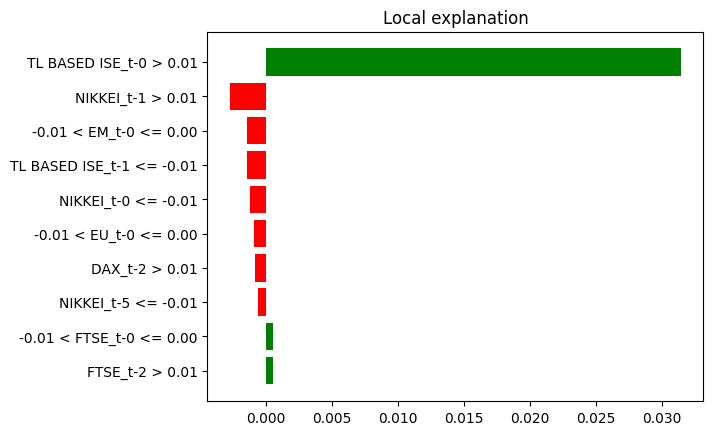

In [144]:
explain_model(X_train, model, X_test[19], input_features)

Let's try to use the model of Istanbul Stock Exchange:

In [30]:
df = pd.read_excel("data_akbilgic.xlsx")

In [31]:
df.tail(14)

date  TL BASED ISE  USD BASED ISE        SP       DAX      FTSE  \
522 2011-02-03     -0.024478      -0.027850  0.002351  0.001392 -0.002804   
523 2011-02-04      0.024507       0.013959  0.002880  0.003127  0.002354   
524 2011-02-07     -0.006196       0.008553  0.006221  0.009298  0.008898   
525 2011-02-08      0.005356       0.006886  0.004176  0.005425  0.006638   
526 2011-02-09      0.004823      -0.003255 -0.002790 -0.000320 -0.006423   
527 2011-02-10     -0.017664      -0.024921  0.000749  0.002644 -0.005351   
528 2011-02-11      0.004782       0.006418  0.005492  0.004204  0.007101   
529 2011-02-14     -0.002498       0.000405  0.002382  0.003444 -0.000462   
530 2011-02-15      0.003606       0.000893 -0.003240  0.000461 -0.003803   
531 2011-02-16      0.008599       0.013400  0.006238  0.001925  0.007952   
532 2011-02-17      0.009310       0.015977  0.003071 -0.001186  0.000345   
533 2011-02-18      0.000191      -0.001653  0.001923  0.002872 -0.000723   
534 2011-02-21     -0.013069      -0.013706 -0.020742 -0.014239 -0.011275   
535 2011-02-22     -0.007246      -0.019442  0.000000 -0.000473 -0.002997   

       NIKKEI   BOVESPA        EU        EM  
522 -0.002489  0.001154 -0.002883  0.000476  
523  0.010695 -0.022662  0.002761 -0.003185  
524  0.004591  0.001424  0.008217 -0.003346  
525  0.004140  0.006238  0.003980 -0.004499  
526 -0.001708 -0.023895 -0.003024 -0.014249  
527 -0.001148  0.005590 -0.003742 -0.014760  
528  0.011241  0.018077  0.004727  0.003931  
529  0.000000  0.012123  0.000169  0.013448  
530  0.001968 -0.003266 -0.000550 -0.001430  
531  0.005717  0.018371  0.006975  0.003039  
532  0.002620  0.001686 -0.000581  0.001039  
533  0.000568  0.005628  0.000572  0.006938  
534  0.001358 -0.011942 -0.012615 -0.000958  
535 -0.017920 -0.012252 -0.005465 -0.014297

<AxesSubplot: >

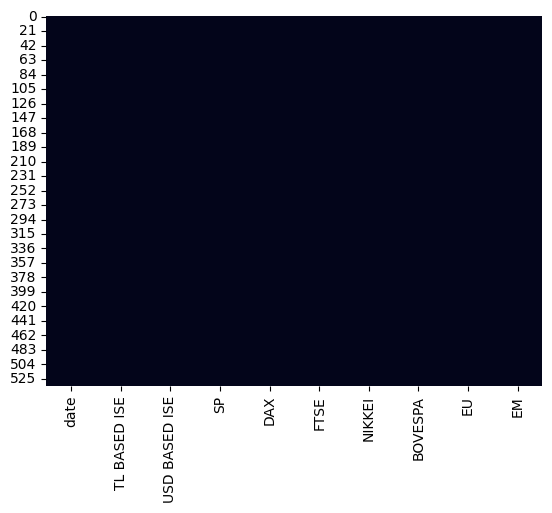

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isna(), cbar=False)

Let's say we want to predict USD Based ISE.

In [33]:
df.set_index('date', inplace=True)
df = df.rename(columns={'USD BASED ISE': 'Y'})

In [34]:
df.head(4)

TL BASED ISE         Y        SP       DAX      FTSE    NIKKEI  \
date                                                                         
2009-01-05      0.035754  0.038376 -0.004679  0.002193  0.003894  0.000000   
2009-01-06      0.025426  0.031813  0.007787  0.008455  0.012866  0.004162   
2009-01-07     -0.028862 -0.026353 -0.030469 -0.017833 -0.028735  0.017293   
2009-01-08     -0.062208 -0.084716  0.003391 -0.011726 -0.000466 -0.040061   

             BOVESPA        EU        EM  
date                                      
2009-01-05  0.031190  0.012698  0.028524  
2009-01-06  0.018920  0.011341  0.008773  
2009-01-07 -0.035899 -0.017073 -0.020015  
2009-01-08  0.028283 -0.005561 -0.019424

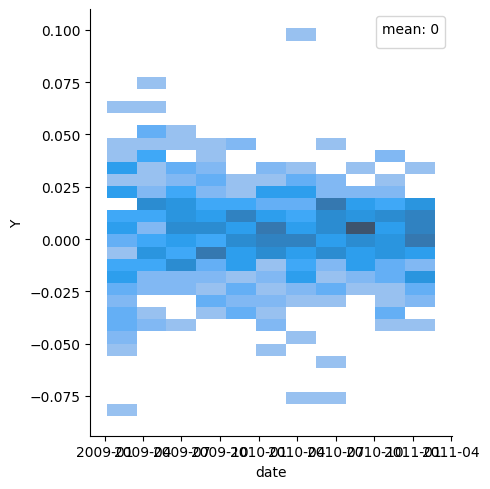

In [35]:
sns.displot(data=df, x='date', y='Y')
plt.legend(title='mean: {:,.0f}'.format(df["Y"].mean()), labels=[])
plt.show()

Let's generate samples, train and test set:

In [36]:
from sklearn.model_selection import train_test_split

features = df.columns.values
index = np.argwhere(features=='Y')
input_features = np.delete(features, index)
output_feature = np.array(['Y'])
window_size = 7
stride = 1

# create lists to store the samples and labels
samples = []
labels = []

# slide the window over the data and extract samples and labels
for i in range(0, len(df) - window_size+1, stride):
    # extract the input features for this window
    X = df.iloc[i:i+window_size, df.columns != 'Y'].values
    samples.append(X)

    # extract the output feature for this window
    y = df.iloc[i+window_size-1][output_feature]
    labels.append(y)

# convert the lists to numpy arrays
samples = np.array(samples)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, shuffle=False)

Now the model:

In [37]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [38]:
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 30ms/step - loss: 4.8083e-04 - val_loss: 2.7019e-04
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6706e-04 - val_loss: 2.9060e-04
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 4.6087e-04 - val_loss: 2.8791e-04
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 4.5477e-04 - val_loss: 2.7620e-04
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 4.5241e-04 - val_loss: 2.7157e-04
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 4.5052e-04 - val_loss: 2.7408e-04
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 4.4746e-04 - val_loss: 2.8050e-04
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 4.4244e-04 - val_loss: 2.7543e-04
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 4.4144e-04 - val_loss: 2.7552e-04
Epoch 10/100
4/4 [==============================] - 0s

In [39]:
y_pred = model.predict(X_test)
print(y_pred)

4/4 [==============================] - 0s 702us/step
[[-0.00515897]
 [ 0.00472302]
 [-0.01072158]
 [-0.0037371 ]
 [ 0.01222523]
 [-0.00060444]
 [-0.00329326]
 [ 0.007073  ]
 [ 0.00404258]
 [ 0.0022104 ]
 [ 0.00324105]
 [-0.00637402]
 [-0.00411057]
 [-0.00923481]
 [-0.00923353]
 [ 0.00497548]
 [ 0.00365133]
 [ 0.00762625]
 [-0.00136111]
 [-0.00944882]
 [-0.00545331]
 [ 0.00824271]
 [-0.01461828]
 [ 0.00200462]
 [ 0.00269862]
 [-0.0110998 ]
 [-0.01026187]
 [-0.0039506 ]
 [-0.00194417]
 [ 0.00308347]
 [-0.02050122]
 [-0.01512771]
 [ 0.00509807]
 [-0.00973779]
 [-0.02384459]
 [ 0.00106802]
 [ 0.00358367]
 [ 0.00308349]
 [-0.01422773]
 [-0.00940413]
 [-0.00099009]
 [-0.00626401]
 [-0.01185199]
 [-0.01722595]
 [-0.00568079]
 [-0.0017486 ]
 [ 0.00239249]
 [-0.0189388 ]
 [-0.00452773]
 [ 0.00397616]
 [ 0.01430739]
 [ 0.00170833]
 [-0.00701695]
 [-0.00415871]
 [-0.00351963]
 [-0.00290182]
 [-0.00443269]
 [-0.01576329]
 [-0.0051086 ]
 [-0.00069693]
 [-0.00967207]
 [-0.00011615]
 [ 0.00473261]
 [

In [40]:
print(y_pred[20])
print(y_test[20])

[-0.00545331]
[-0.00814098]


In [41]:
print(mean_absolute_error(y_pred, y_test))

0.014564713176184007


Ok now let's see the LIME explanation:

2813/2813 [==============================] - 1s 377us/step
Predicted LIME Value:  [0.01195577]
('BOVESPA_t-1 > 0.01', 0.008091964659604118)
('SP_t-1 > 0.01', 0.006966622470365491)
('FTSE_t-3 > 0.01', 0.006438517335582877)
('DAX_t-2 <= -0.01', 0.004562179699197018)
('BOVESPA_t-3 > 0.01', 0.003961969620274739)
('DAX_t-1 > 0.01', -0.0036463865162122983)
('NIKKEI_t-1 > 0.01', -0.0036332475435685223)
('TL BASED ISE_t-6 > 0.01', -0.0026486340317027255)
('EU_t-1 > 0.01', -0.0018680384556359474)
('TL BASED ISE_t-1 > 0.01', 0.0018003454414871275)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
('BOVESPA_t-1 > 0.01', 0.008091964659604118)  Miao
('SP_t-1 > 0.01', 0.006966622470365491)  Miao
('FTSE_t-3 > 0.01', 0.006438517335582877)  Miao
('DAX_t-2 <= -0.01', 0.004562179699197018)  Miao
('BOVESPA_t-3 > 0.01', 0.003961969620274739)  Miao
('DAX_t-1 > 0.01', -0.0036463865162122983)  Miao
('NIKKEI_t-1 > 0.01', -0.0036332475435685223)  Miao
('TL BASED ISE_t-6 > 0.01', -0.0026486340317027255)  Miao
('EU_t-1 > 0.01', -0.0018680384556359474)  Miao
('TL BASED ISE_t-1 > 0.01', 0.0018003454414871275)  Miao


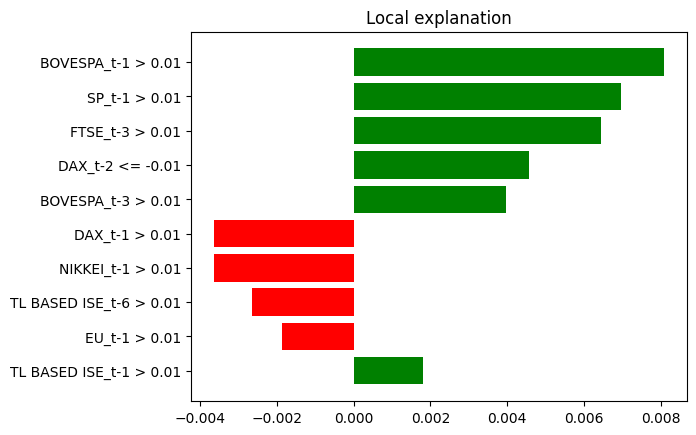

In [42]:
explain_model(X_train, model, X_test[12], features_names=input_features)

Let's try with LSTM:

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [44]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
14/14 [==============================] - 1s 21ms/step - loss: 4.9357e-04 - val_loss: 2.5716e-04
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3.7743e-04 - val_loss: 2.2010e-04
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3.6377e-04 - val_loss: 1.9459e-04
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 2.8382e-04 - val_loss: 1.9247e-04
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 2.4227e-04 - val_loss: 1.4252e-04
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 2.0193e-04 - val_loss: 1.2737e-04
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 1.7318e-04 - val_loss: 1.1779e-04
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 1.5446e-04 - val_loss: 1.1677e-04
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 1.3928e-04 - val_loss: 9.7421e-05
Epoch 10/100
14/14 [================

In [45]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

4/4 [==============================] - 0s 1ms/step
0.004650649331532934


In [46]:
print(y_pred[19])
print(y_test[19])

[0.00738537]
[0.0076885]


2813/2813 [==============================] - 2s 699us/step
Predicted LIME Value:  [0.0197499]
('TL BASED ISE_t-0 > 0.01', 0.031729709307063335)
('NIKKEI_t-1 > 0.01', -0.0026422357274866505)
('-0.01 < EM_t-0 <= 0.00', -0.001332173438495948)
('TL BASED ISE_t-1 <= -0.01', -0.0012656331633843488)
('NIKKEI_t-0 <= -0.01', -0.001142503706893387)
('DAX_t-2 > 0.01', -0.0009182776504809019)
('-0.01 < EU_t-0 <= 0.00', -0.0008928655992859638)
('0.00 < BOVESPA_t-0 <= 0.01', -0.0006821030399597223)
('0.00 < DAX_t-0 <= 0.01', -0.0006542464306631921)
('FTSE_t-2 > 0.01', 0.0005752306118430154)


Based on the LIME explanation, the following features had the most influence on the model's prediction:
('TL BASED ISE_t-0 > 0.01', 0.031729709307063335)  Miao
('NIKKEI_t-1 > 0.01', -0.0026422357274866505)  Miao
('-0.01 < EM_t-0 <= 0.00', -0.001332173438495948)  Miao
('TL BASED ISE_t-1 <= -0.01', -0.0012656331633843488)  Miao
('NIKKEI_t-0 <= -0.01', -0.001142503706893387)  Miao
('DAX_t-2 > 0.01', -0.0009182776504809019)  Miao
('-0.01 < EU_t-0 <= 0.00', -0.0008928655992859638)  Miao
('0.00 < BOVESPA_t-0 <= 0.01', -0.0006821030399597223)  Miao
('0.00 < DAX_t-0 <= 0.01', -0.0006542464306631921)  Miao
('FTSE_t-2 > 0.01', 0.0005752306118430154)  Miao


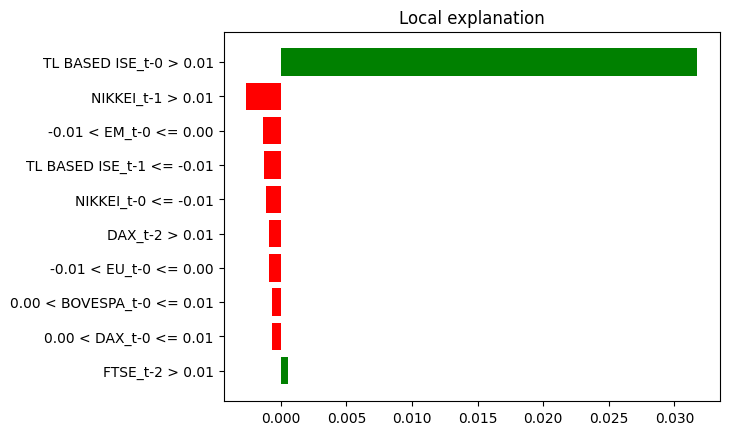

In [47]:
explain_model(X_train, model, X_test[19], input_features)